# Dataset Statistics for Disease Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel

# Read Full Sentence Table

The cells below will read every sentence that contains a gene and disease entity from the sentence table in our postgres database. For time sake majority of the data has already been processed and save as files mentioned below.

In [5]:
sql= '''
select id as sentence_id, text, (
    char_length(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g')) - 
    char_length(regexp_replace(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g'), ',', '','g'))
) as sen_length, entity_types 
from sentence 
where entity_types::text like '%%Gene%%' or entity_types::text like '%%Disease%%';
'''
sentence_df = pd.read_sql(sql, database_str)
sentence_df.head(2)

,sentence_id,text,sen_length,entity_types
0,50306,[Chronorogical changes in activities of variou...,28,"[O, O, O, O, O, O, O, O, O, Gene, O, O, O, O, ..."
1,50312,[Prophylaxis of immediate and delayed reaction...,18,"[O, O, O, O, O, O, O, O, O, O, Disease, Diseas..."


In [8]:
entity_data = []
tagging_error_ids = set({})

#skip tagging error
skip_tag_error = False
for index, row in tqdm_notebook(sentence_df.iterrows()):
    
    #create dictionay for mapping entity types
    entity_mapper = {"sentence_id": row['sentence_id']}
    
    #Keep track of previous entity
    previous_entity = 'o'
    
    #For all entitys in a given sentence decide what is tagged
    for entity in row['entity_types']:
        entity = entity.lower()

        #Non-O tag
        if entity != 'o' and previous_entity =='o':
            #If entity not seen before instanciate it
            if entity not in entity_mapper:
                entity_mapper[entity] =0
            entity_mapper[entity] += 1

        # If previous tag was non-O and the current tag does not equal previous
        # Then tagging error. e.x. Disease, Gene, Disease instead of Disease, O, Disease
        elif entity != previous_entity and entity != 'o':
            tagging_error_ids.add(row['sentence_id'])
            skip_tag_error = True
            break

        previous_entity = entity
    
    # Do not add errors to dataframe
    # They will be thrown out
    if not skip_tag_error:
        entity_data.append(entity_mapper)

    skip_tag_error=False
    
entity_stats_df = pd.DataFrame.from_dict(entity_data).fillna(0)
entity_stats_df.head(2)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

,compound,disease,gene,sentence_id
0,0.0,0.0,1.0,50306
1,0.0,1.0,0.0,50312


In [9]:
tagging_error_df = pd.Series(sorted(list(tagging_error_ids)))
tagging_error_df.to_csv("data/tagging_error_ids.tsv.xz", sep="\t",  index=False, compression="xz")
tagging_error_df.head(2)

0    50639
1    50719
dtype: int64

In [14]:
print(
    "Total Number of IOB Tagging Errors: {}. Percentage of sentences affected: {:.2f}".format(
        tagging_error_df.shape[0],
        100*tagging_error_df.shape[0]/sentence_df.shape[0]
    )
)

Total Number of IOB Tagging Errors: 284297. Percentage of sentences affected: 1.14


In [13]:
header = ["sentence_id", "text", "sen_length"]
sentence_df[header].to_csv("data/sentence_stats.tsv.xz", sep="\t", index=False, compression="xz")
entity_stats_df.to_csv("data/entity_stats.tsv.xz", sep="\t",  index=False, compression="xz")

# Sentence Counts and Statistics

Below is the block of code that contains information about the full distribution of sentences tied to each candidate pair. Multiple sentences can contain more than one co-occuring pair, which results in some sentences being counted more than once.

## Load and Merge DataFrames

In [5]:
entity_level_df = pd.read_csv("../disease_gene_pairs_association.csv.xz")
entity_level_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.85860,1
1,1,A1BG,DOID:1319,brain cancer,NaN,0,0,0,0.36785,0


In [6]:
entity_stats_df = pd.read_table("data/entity_stats.tsv.xz")
entity_stats_df.head(2)

,compound,disease,gene,sentence_id
0,0.0,0.0,1.0,50306
1,0.0,1.0,0.0,50312


In [7]:
sentence_count_df = pd.read_table("data/sentence_stats.tsv.xz")
sentence_count_df.head(2)

,sentence_id,text,sen_length
0,50306,[Chronorogical changes in activities of variou...,28
1,50312,[Prophylaxis of immediate and delayed reaction...,18


In [8]:
sentence_sql = '''
select cand_id, "Disease_cid", "Gene_cid", sentence_id from (
select disease_gene.id as "cand_id", disease_gene."Disease_id",  disease_gene."Disease_cid", disease_gene."Gene_cid", candidate.split from disease_gene 
inner join candidate on disease_gene.id=candidate.id 
where split={}
) as candidate_splits inner join span on candidate_splits."Disease_id"=span.id;
'''

In [9]:
train_candidate_df = pd.read_sql(sentence_sql.format(0), database_str)
train_candidate_df.head(2)

,cand_id,Disease_cid,Gene_cid,sentence_id
0,21584,DOID:5408,5741,528427
1,21658,DOID:2355,3105,93123


In [10]:
dev_candidate_df = pd.read_sql(sentence_sql.format(1), database_str)
test_candidate_df = pd.read_sql(sentence_sql.format(2), database_str)

In [11]:
clean_up_df = lambda x: (
        entity_stats_df
        .merge(sentence_count_df, on="sentence_id")
        .merge(x, on="sentence_id")
        .rename(index=str, columns={
            "disease":"disease_mention_count", 
            "gene":"gene_mention_count", 
            "compound":"compound_mention_count",
            "cand_id": "candidate_id",
            "Disease_cid": "doid_id",
            "Gene_cid": "entrez_gene_id"
        })
        .astype({"entrez_gene_id": int})
    )

In [12]:
train_candidate_df = clean_up_df(train_candidate_df)
train_candidate_df.head(2)

,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id,doid_id,entrez_gene_id
0,0.0,1.0,1.0,50638,Thyrotropin response to thyrotropin-releasing ...,16,22250,DOID:1595,7200
1,0.0,1.0,2.0,51109,The levels of CA-B and CA-C were determined in...,29,22455,DOID:1459,760


In [13]:
dev_candidate_df = clean_up_df(dev_candidate_df)
test_candidate_df = clean_up_df(test_candidate_df)

In [14]:
training_set_df = (
    entity_level_df
    .query("split==0&has_sentence==1")
    .merge(
        train_candidate_df, 
        on=["entrez_gene_id", "doid_id"]
    )
)
training_set_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0,0.0,1.0,2.0,78840952,We revealed that A1BG and LRG1 were overexpres...,30,26725291
1,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0,0.0,1.0,1.0,86234572,METHODS: HEK293 cells expressing specific indi...,53,29874761


In [15]:
dev_set_df = (
    entity_level_df
    .query("split==1&has_sentence==1")
    .merge(
        dev_candidate_df, 
        on=["entrez_gene_id", "doid_id"]
    )
)

test_set_df = (
    entity_level_df
    .query("split==2&has_sentence==1")
    .merge(
        test_candidate_df, 
        on=["entrez_gene_id", "doid_id"]
    )
)

In [16]:
total_candidates_df = (
    training_set_df
    .append(dev_set_df)
    .append(test_set_df)
)

## Distribution of Sentence Length

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


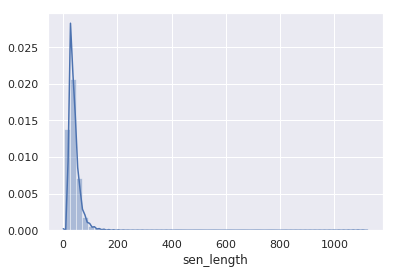

In [17]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [18]:
total_candidates_df["sen_length"].describe().astype(int)

count    3563272
mean          37
std           23
min            3
25%           23
50%           33
75%           46
max         1120
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of words (tokens) for a given sentence is in the thousands range. Intuitively, that doesn't make sense, since the average number of words for a given sentence is 37. Possible reason for this abnormality is a parsing error. Lets take a look at this 1120 word sentence.

In [19]:
total_candidates_df.query("sen_length==1120").iloc[0]["text"]

'Pooled analysis of (R)-[11C]-verapamil PET data from two European centresM Bauer, M Feldmann, R Karch, W Wadsak, M Zeitlinger, MJ Koepp, M-C Asselin, E Pataraia, O LangerA13 In-vitro and in-vivo characterization of [18F]FE@SNAP and derivatives for the visualization of the melanin concentrating hormone receptor 1M Zeilinger, C Philippe, M Dumanic, F Pichler, J Pilz, M Hacker, W Wadsak, M MitterhauserA14 Reducing time in quality control leads to higher specific radioactivity of short-lived radiotracersL Nics, B Steiner, M Hacker, M Mitterhauser, W WadsakA15 In vitro 11C-erlotinib binding experiments in cancer cell lines with epidermal growth factor receptor mutationsA Traxl, Thomas Wanek, Kushtrim Kryeziu, Severin Mairinger, Johann Stanek, Walter Berger, Claudia Kuntner, Oliver LangerA16 7-[11C]methyl-6-bromopurine, a PET tracer to measure brain Mrp1 function: radiosynthesis and first PET evaluation in miceS Mairinger, T Wanek, A Traxl, M Krohn, J Stanek, T Filip, M Sauberer, C Kuntner,

The above suspicion was correct. This is a parsing error where the list of authors are combined with the title of their work for a winter symposium. The following can be found at this id link: [27090254](https://www.ncbi.nlm.nih.gov/pubmed/27090254). The goal here is to take these parsing errors into account and determine an optimal cutoff point for these sentences. Using common statsitic rules any point that is greater than two standard deviations away from the mean will be removed.

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


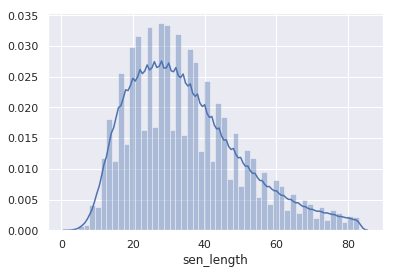

In [20]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [21]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    3429890
mean          34
std           15
min            3
25%           23
50%           32
75%           44
max           83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 3.6 million. (removed 146841 sentences).

In [22]:
before_filter = set([tuple(line) for line in total_candidates_df[["entrez_gene_id", "doid_id"]].values])
after_filter = set([tuple(line) for line in total_candidates_df.query("sen_length < 83+1")[["entrez_gene_id", "doid_id"]].values])
print(
    "Total number of unique candidates before filter: {}".format(
        total_candidates_df[["entrez_gene_id", "doid_id"]].drop_duplicates().shape[0]
    )
)
print(
    "Total number of unique candidates after filter: {}".format(
        total_candidates_df.query("sen_length < 83+1")[["entrez_gene_id", "doid_id"]].drop_duplicates().shape[0]
    )
)
print("Total number of unique candidates being thrown out: {}".format(len(before_filter.difference(after_filter))))

Total number of unique candidates before filter: 156954
Total number of unique candidates after filter: 153162
Total number of unique candidates being thrown out: 3792


In [23]:
filtered_total_candidates_df = total_candidates_df.query("sen_length < 83+1")

Text(0.5,1,'# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet')

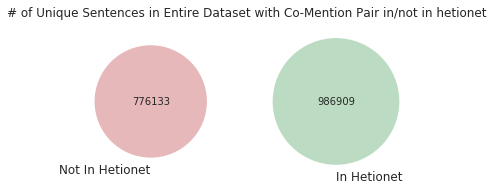

In [24]:
ids =filtered_total_candidates_df.query("hetionet==1").sentence_id.values
venn2(
    [
        set(filtered_total_candidates_df.query("hetionet==0&sentence_id not in @ids").sentence_id),
        set(filtered_total_candidates_df.query("hetionet==1").sentence_id)
    ], set_labels=["Not In Hetionet", "In Hetionet"])
plt.title("# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet")

# Co-occuring Mentions Sentence Stats

This next block contains a visualization about the number of mentions a sentence may contain.

Text(0.5,1,'Mention Distribution of Entire Dataset')

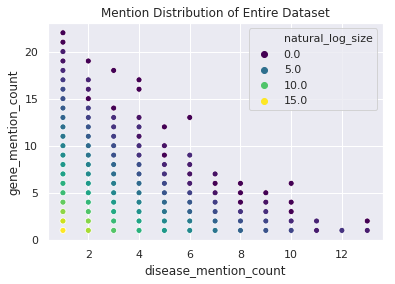

In [56]:
ax = sns.scatterplot(
    x="disease_mention_count", 
    y="gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .drop_duplicates("sentence_id")
        .groupby(["disease_mention_count", "gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Mention Distribution of Entire Dataset")

In the above graph every point is group of possible mention counts sentences could contain. For example one group has sentences containing one gene mention and one disease mention (indicated in the bottom left in yellow). Overall this graph is acceptable in terms of the spread between mentions; however, when getting ready to train the deep learning models one has to make sure the algorithm can detect which co-mention pair the candidate is referring to.

# Subsampled Set Distributions

Take a look at the stratification for each train/dev/test set.

## Training Set

Here the training set covers majority of the characterisitics are the entire dataset. This isn't surprising because a stratified sort was used to allocate candidates.

Text(0.5,1,'Distribution of Sentences in Subsampled Training Set')

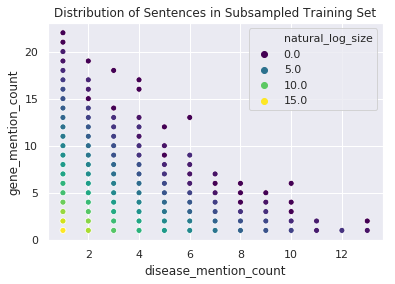

In [57]:
ax = sns.scatterplot(
    x="disease_mention_count", 
    y="gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==0")
        .drop_duplicates("sentence_id")
        .groupby(["disease_mention_count", "gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Distribution of Sentences in Entire Training Set")

## Dev Set

This block contains information on the development set (aka tuning set).

Text(0.5,1,'Sentence Distribution of Total Dev Dataset')

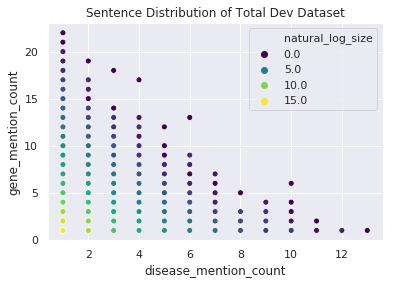

In [58]:
ax = sns.scatterplot(
    x="disease_mention_count", 
    y="gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==1")
        .drop_duplicates("sentence_id")
        .groupby(["disease_mention_count", "gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Total Dev Dataset")

In [59]:
dev_dataset_df = pd.read_excel("sentence_labels_dev.xlsx").query("curated_dsh.notnull()")

In [60]:
dev_candidates_stats_df = (
    filtered_total_candidates_df
    .query("split==1")
    .merge(dev_dataset_df[["candidate_id", "curated_dsh"]], on="candidate_id")
)
print("Total number of positives (1) and negatives (0): \n{}".format(dev_candidates_stats_df.curated_dsh.value_counts()))

Total number of positives (1) and negatives (0): 
0.0    421
1.0    271
Name: curated_dsh, dtype: int64


Text(0.5,1,'Sentence Distribution of Hand Labeled Dev Dataset')

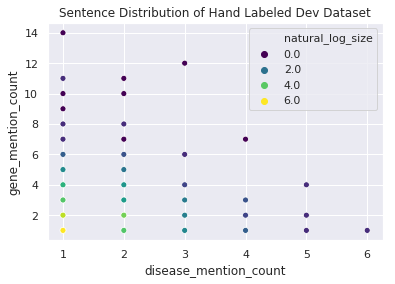

In [62]:
ax = sns.scatterplot(
    x="disease_mention_count", 
    y="gene_mention_count", 
    data=
    (
        dev_candidates_stats_df
        .drop_duplicates("sentence_id")
        .groupby(["disease_mention_count", "gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Hand Labeled Dev Dataset")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


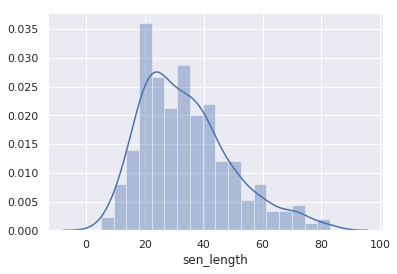

In [63]:
sns.distplot(dev_candidates_stats_df["sen_length"], rug=False)

## Test Set

Text(0.5,1,'Sentence Distribution of Total Test Dataset')

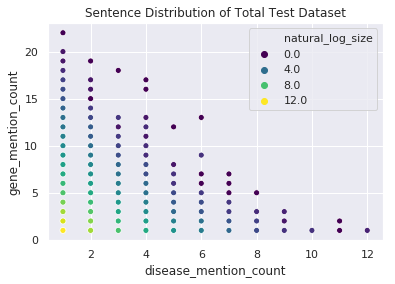

In [64]:
ax = sns.scatterplot(
    x="disease_mention_count", 
    y="gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==2")
        .drop_duplicates("sentence_id")
        .groupby(["disease_mention_count", "gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Total Test Dataset")

In [65]:
test_dataset_df = pd.read_excel("sentence_labels_test.xlsx").query("curated_dsh.notnull()")

In [66]:
test_candidates_stats_df = (
    filtered_total_candidates_df
    .query("split==2")
    .merge(test_dataset_df[["candidate_id", "curated_dsh"]], on="candidate_id")
)
print("Total number of positives (1) and negatives (0): \n{}".format(test_candidates_stats_df.curated_dsh.value_counts()))

Total number of positives (1) and negatives (0): 
0.0    574
1.0    335
Name: curated_dsh, dtype: int64


Text(0.5,1,'Sentence Distribution of Hand Labeled Test Dataset')

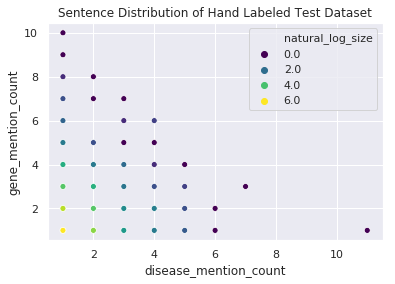

In [118]:
ax = sns.scatterplot(
    x="disease_mention_count", 
    y="gene_mention_count", 
    data=
    (
        test_candidates_stats_df
        .drop_duplicates("sentence_id")
        .groupby(["disease_mention_count", "gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Hand Labeled Test Dataset")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


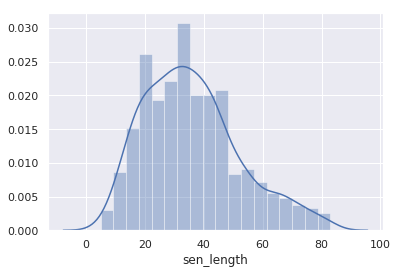

In [68]:
sns.distplot(test_candidates_stats_df["sen_length"], rug=False)

In conclusion, the optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance. Another important lesson is to analyze one's dataset before undergoing the journey of training a deep learning model. Sentence length is an important factor, when it comes to filtering out the dataset. If ignored, a significant amount of problems will arise. For example, when training a long short term memory network (LSTM), sequence length dictates how many steps the LSTM needs to traverse in order to ultimately calculate the probability of a sentence mentioning a relationship. If the LSTM were to be fed a sentence that contains 1120 words, then the network has 1120 steps to parse through. This takes a significant amount of time (~34 hours+). Plus during backpropogation, the gradient will become very small that the network cannot learn anything useful ([Backpropogation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time)). 